In [26]:
# import data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
df = pd.read_csv("pcap_kpis_detailed.csv")

# Quick preview
df.head()


,file,node_type,network_type,total_packets,avg_pkt_size,std_pkt_size,min_pkt_size,max_pkt_size,avg_inter_pkt_time,std_inter_pkt_time,...,unique_src_ports,unique_dst_ports,unique_tos_values,avg_dscp,unique_dscp,non_zero_dscp,dscp_marking_ratio,dns_queries,dns_responses,dns_ratio
0,bot-wifi-0-6-1.pcap,bot,wifi,461,72.045553,28.430760,14,134,0.104081,0.686852,...,0,0,0,0,0,0,0,0,0,0
1,bot-wifi-0-7-1.pcap,bot,wifi,75,58.266667,45.344410,14,134,0.282201,1.568606,...,0,0,0,0,0,0,0,0,0,0
2,bot-wifi-1-8-1.pcap,bot,wifi,521,72.815739,30.541068,14,134,0.092070,0.646663,...,0,0,0,0,0,0,0,0,0,0
3,bot-wifi-1-9-1.pcap,bot,wifi,101,60.455446,44.834244,14,134,0.208830,1.354940,...,0,0,0,0,0,0,0,0,0,0
4,bot-wifi-10-24-1.pcap,bot,wifi,1616,121.519802,76.686651,14,202,0.043243,0.049391,...,0,0,0,0,0,0,0,0,0,0


# Distributions

## avg_pkt_size distribution (first plot)

 - Humans likely generate a wider range of packet sizes due to varied application use

## avg_inter_pkt_time (second plot)

 - Humans are potentially more likely to have long idle intervals

 - Bots usually operate at very consistent timing

## pkt_size_entropy (third plot)

 - High entropy = diverse packet sizes → likely human

 - Low entropy = repetitive sizes → likely bot or automated tools


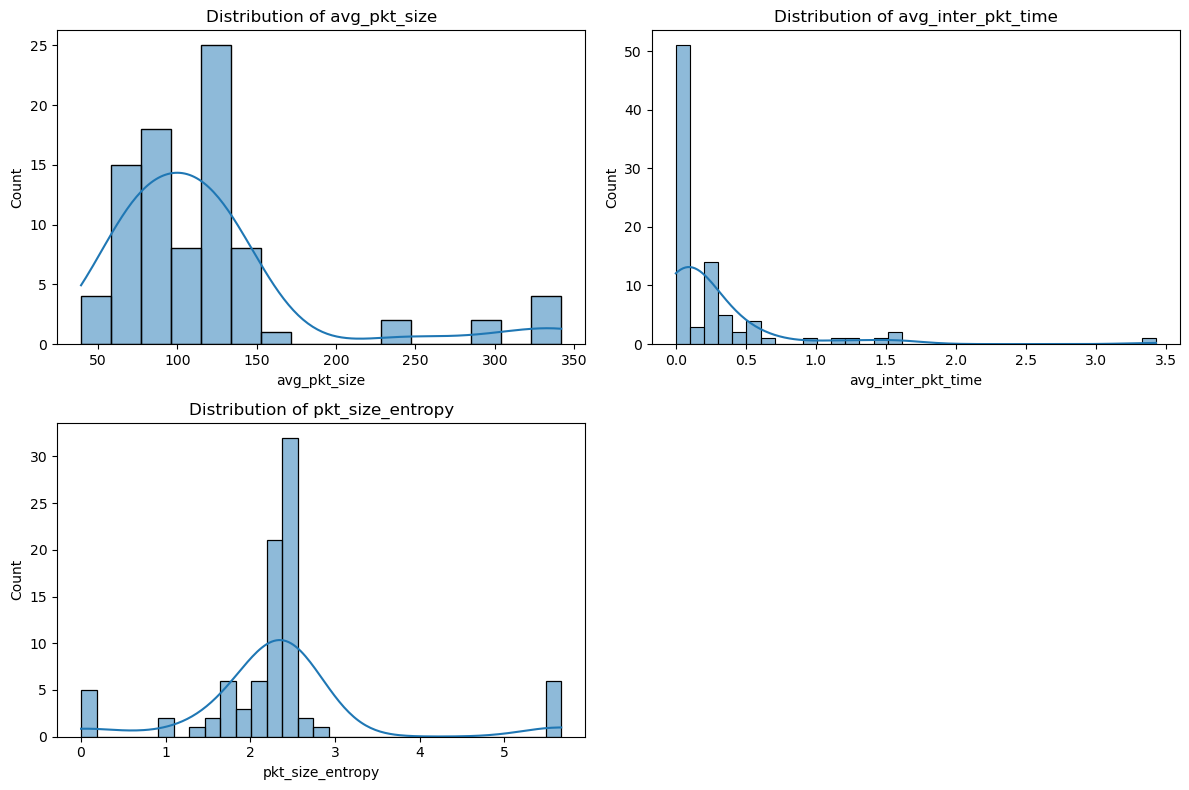

In [30]:
hist_cols = [
    "avg_pkt_size",
    "avg_inter_pkt_time",
    "pkt_size_entropy"
]

plt.figure(figsize=(12, 8))
for i, col in enumerate(hist_cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()


# boxplots

## avg_pkt_size (plot one)

 - Humans show larger spread and higher outliers

 - Bots have smaller, more compact values

So, Humans send more varied and sometimes larger packets

## timing_regularity (plot two)

 - Bots appear slightly more regular

 - Humans slightly less regular

As expected, bots tend to send packets on predictable schedules

## burst_factor (plot three)

 - Humans show higher max burstiness

 - Bots stay within lower, narrower ranges

Human applications produce more extreme bursts 
 - scrolling, streaming, page loads

## pkt_size_entropy (plot four)

Humans 
 - higher variability in packet sizes
Bots 
 - repetitive behavior
 - low entropy

## avg_inter_pkt_time (plot five)

Bots are more predictable
 - Bots exhibit more uniform behavior
   - Narrow packet-size range
   - Lower entropy
   - More regular timing

Humans generate more bursty, unpredictable traffic
 - Higher variance
 - Outliers in packet sizes, timing, and entropy
 - Bursts in packets-per-second

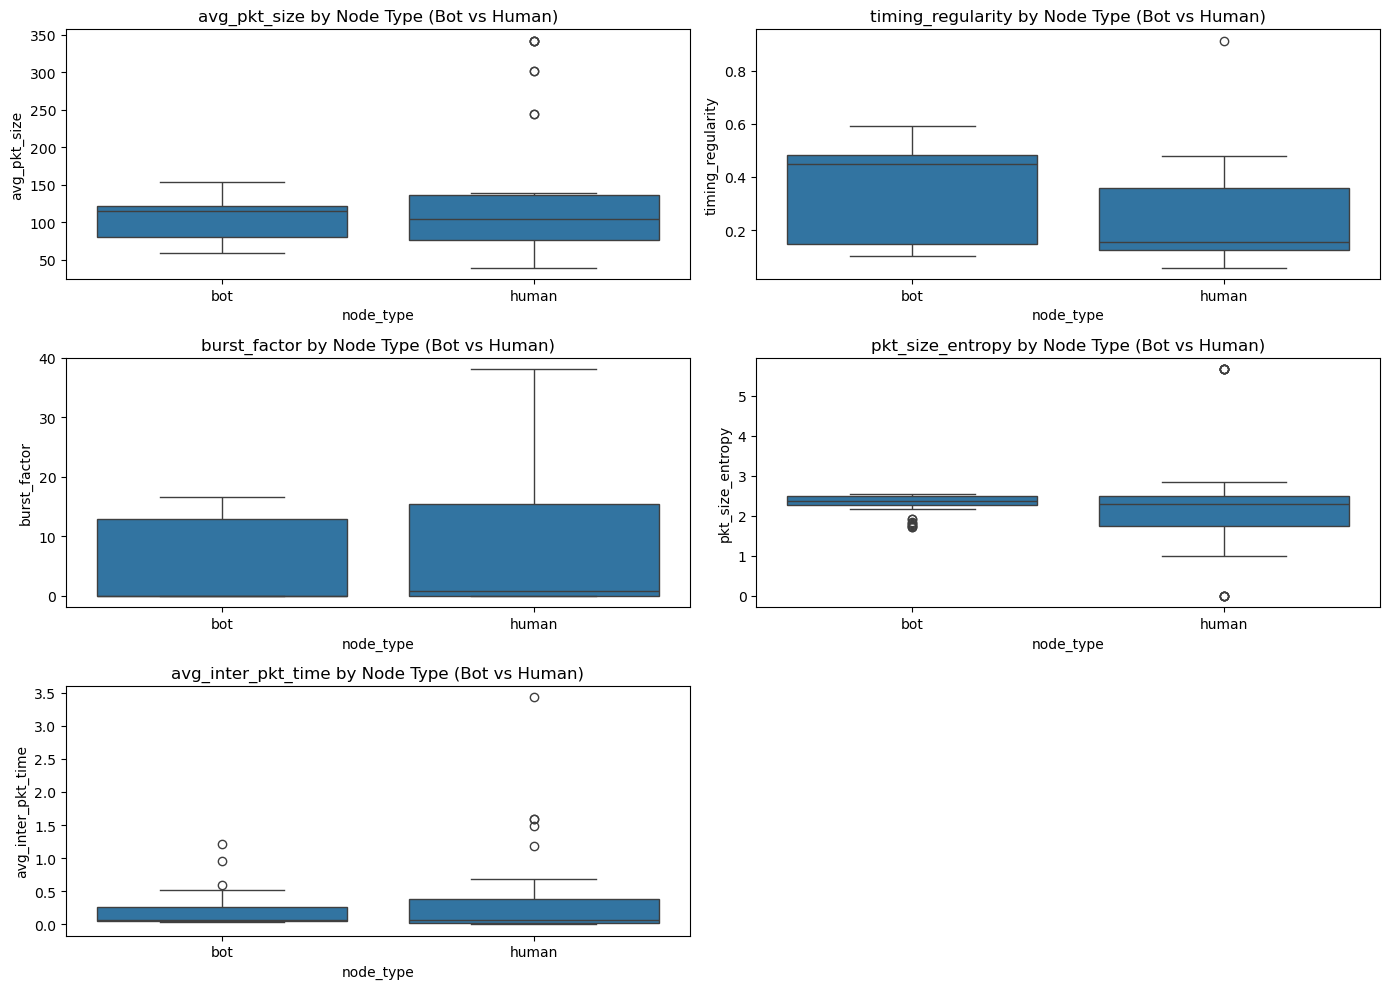

In [9]:
boxplot_cols = [
    "avg_pkt_size",
    "timing_regularity",
    "burst_factor",
    "pkt_size_entropy",
    "avg_inter_pkt_time"
]

plt.figure(figsize=(14, 10))
for i, col in enumerate(boxplot_cols, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(data=df, x="node_type", y=col)
    plt.title(f"{col} by Node Type (Bot vs Human)")
plt.tight_layout()
plt.show()


# bot/human analysis stats

In [11]:
bot_stats = df[df["node_type"] == "bot"].describe()
human_stats = df[df["node_type"] == "human"].describe()

bot_stats, human_stats


(       total_packets  avg_pkt_size  std_pkt_size  min_pkt_size  max_pkt_size  \
 count      49.000000     49.000000     49.000000          49.0     49.000000   
 mean      860.653061    104.854720     63.181129          14.0    172.857143   
 std       682.885226     27.890028     19.075659           0.0     34.000000   
 min        38.000000     58.266667     28.430760          14.0    134.000000   
 25%       164.000000     79.732394     43.911594          14.0    134.000000   
 50%       587.000000    115.044101     76.855824          14.0    202.000000   
 75%      1571.000000    121.740325     79.617280          14.0    202.000000   
 max      1815.000000    152.775618     82.347997          14.0    202.000000   
 
        avg_inter_pkt_time  std_inter_pkt_time  min_inter_pkt_time  \
 count           49.000000           49.000000           49.000000   
 mean             0.179858            0.895337            0.000051   
 std              0.235699            1.179310            0

In [39]:
features = [
    "avg_inter_pkt_time", "timing_regularity", "timing_cv", "burst_factor",
    "pkt_size_entropy", "src_port_entropy", "dst_port_entropy",
    "tcp_syn_count", "tcp_fin_count", "tcp_rst_count",
    "tcp_ratio", "udp_ratio"
]

df.groupby("node_type")[features].mean().T


node_type,bot,human
avg_inter_pkt_time,0.179858,0.372762
timing_regularity,0.343000,0.240422
timing_cv,3.360453,5.710990
burst_factor,5.355377,7.405009
pkt_size_entropy,2.302127,2.441649
src_port_entropy,0.000000,0.149252
dst_port_entropy,0.000000,0.149490
tcp_syn_count,0.000000,32.000000
tcp_fin_count,0.000000,0.000000
tcp_rst_count,0.000000,0.000000


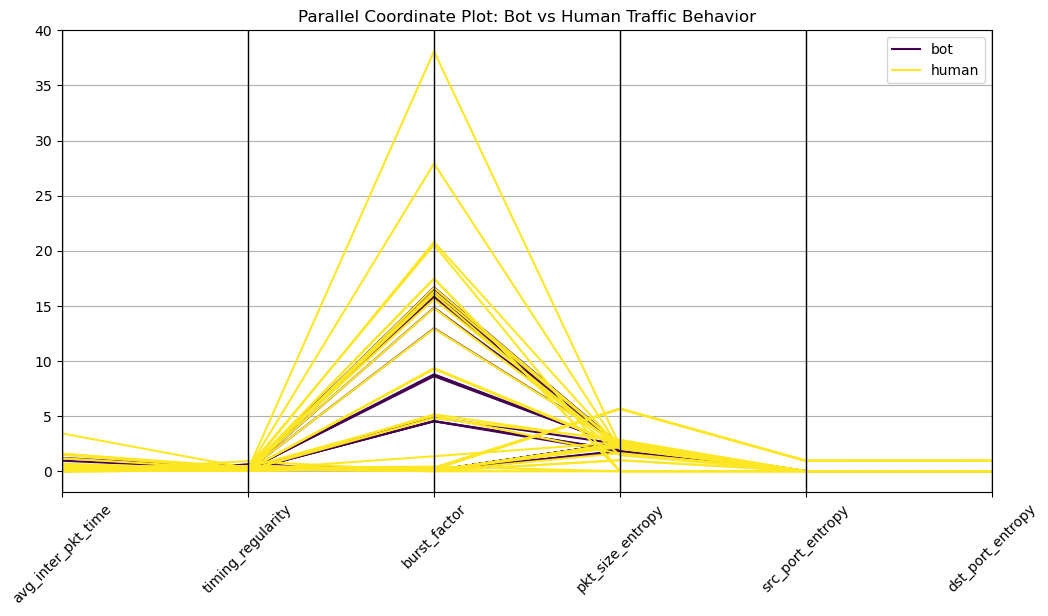

In [16]:
from pandas.plotting import parallel_coordinates
import matplotlib.pyplot as plt

pcp_df = df[[
    "node_type",
    "avg_inter_pkt_time",
    "timing_regularity",
    "burst_factor",
    "pkt_size_entropy",
    "src_port_entropy",
    "dst_port_entropy"
]]

plt.figure(figsize=(12,6))
parallel_coordinates(pcp_df, "node_type", colormap="viridis")
plt.title("Parallel Coordinate Plot: Bot vs Human Traffic Behavior")
plt.xticks(rotation=45)
plt.show()


# wifi vs 5g

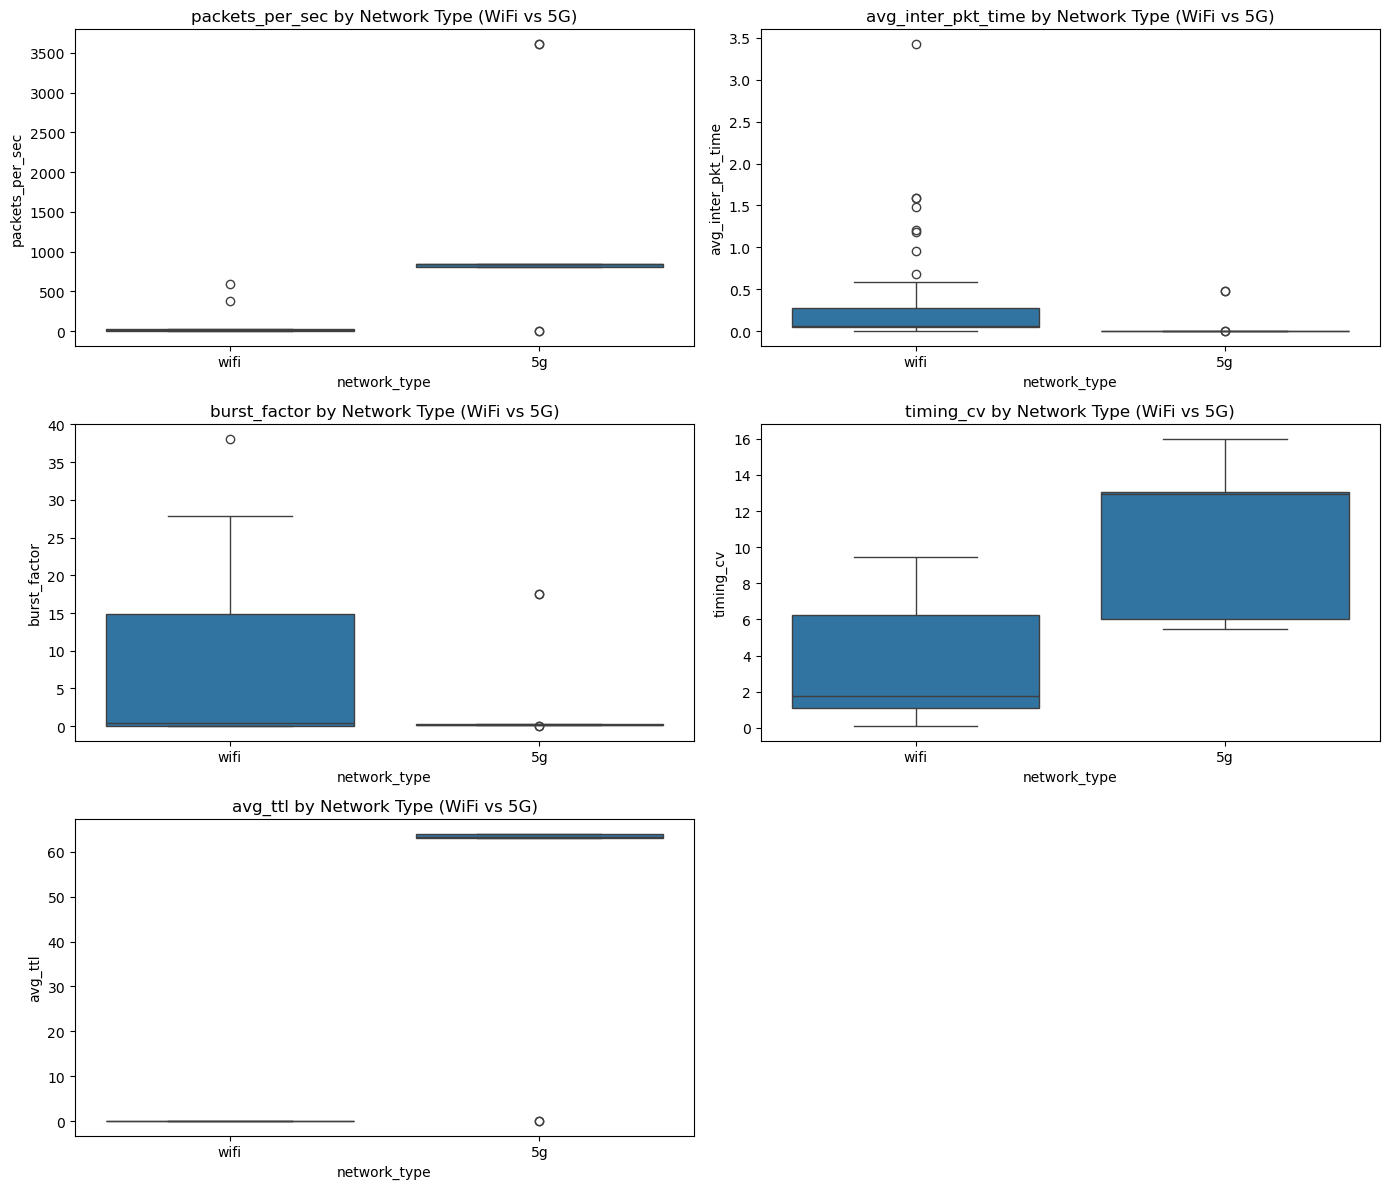

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

compare_cols = [
    "packets_per_sec",
    "avg_inter_pkt_time",
    "burst_factor",
    "timing_cv",
    "avg_ttl"
]

plt.figure(figsize=(14, 12))
for i, col in enumerate(compare_cols, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(data=df, x="network_type", y=col)
    plt.title(f"{col} by Network Type (WiFi vs 5G)")
plt.tight_layout()
plt.show()
